# Klasse G versterkers

<a href="./slides/Klasse-G.slides.html">![sildes](https://img.shields.io/badge/slides-beschikbaar-blue)</a> 

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from  matplotlib import patches
import scipy.signal as signal
import numpy as np
from PySpice.Probe.Plot import plot
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import schemdraw as schem
import schemdraw.elements as e
from ipywidgets import interact,FloatSlider
usewidgets=True;
    
def spicelisting(filename):
    with open(filename) as f:
        for line in f:
            print(line.strip())
    print()

### Basisschema 

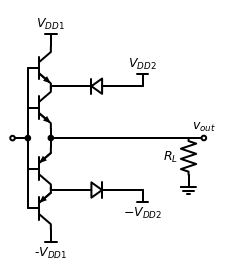

In [24]:
d = schem.Drawing()
T1 = d.add(e.BJT_NPN)
d.add(e.LINE, xy=T1.base, d='down', l=1.3)
T1s = d.add(e.BJT_NPN, d='right')
d.add(e.LINE, xy=T1s.base, d='down', l=1)
indot=d.add(e.DOT)
d.add(e.LINE, d='down', l=1)
T2s = d.add(e.BJT_PNP, d='right')
d.add(e.LINE, xy=T2s.base, d='down', l=1.3)
T2 = d.add(e.BJT_PNP, d='right')

d.add(e.VDD, xy=T1.collector,  label='$V_{DD1}$')
d.add(e.DIODE,xy=T1s.collector,reverse=True, d='right') 
d.add(e.VDD,  label='$V_{DD2}$')

d.add(e.VSS, xy=T2.collector,label='-$V_{DD1}$')
d.add(e.DIODE,xy=T2s.collector,d='right') 
d.add(e.VSS,  label='$-V_{DD2}$')

d.add(e.LINE, xy=indot.start, d='left', l=0.5)
d.add(e.DOT_OPEN)

d.add(e.LINE, d='down',xy=T1s.emitter, l=0.3)
outdot=d.add(e.DOT)
d.add(e.LINE, d='down',toy=T2s.emitter)

d.add(e.LINE,xy=outdot.start,  d='right', l=4.5)
R = d.add(e.RES, d='down',l=1.2, label='$R_L$')
d.add(e.GND)
d.add(e.LINE, xy=R.start, d='right', l=0.5)
dot=d.add(e.DOT_OPEN, label='$v_{out}$')

d.draw()

In [38]:
spicelisting("simul\classG1.sp")

Klasse G versterker
*
* SUPPLY VOLTAGES
VPOS1 8 0 DC	+70
VNEG1 6 0 DC	-70V
VPOS2 5 0 DC	+20V
VNEG2 4 0 DC	-20V
*
*  input source
VS1 1 0	DC 0 SIN(0V 48VPEAK 10KHZ)
*
*  PUSH-PULL TRANSISTOR OUTPUT STAGE
Q1h 8 1 9 QNPN
Q1s 9 12 2 QNPN
Q2s 7 13 2 QPNP
Q2h 6 1 7 QPNP
*
Dpos 5 9 DNOM
Dneg 7 4 DNOM
*
*compensatie Vsat
Db1 1 12 DNOM
Db4 13 1 DNOM
*
* Load resistance
RL1 2 0	8
*
* DEVICE MODELS
.model QNPN NPN(BF=50)
.model QPNP PNP(BF=50)
.model DNOM D()



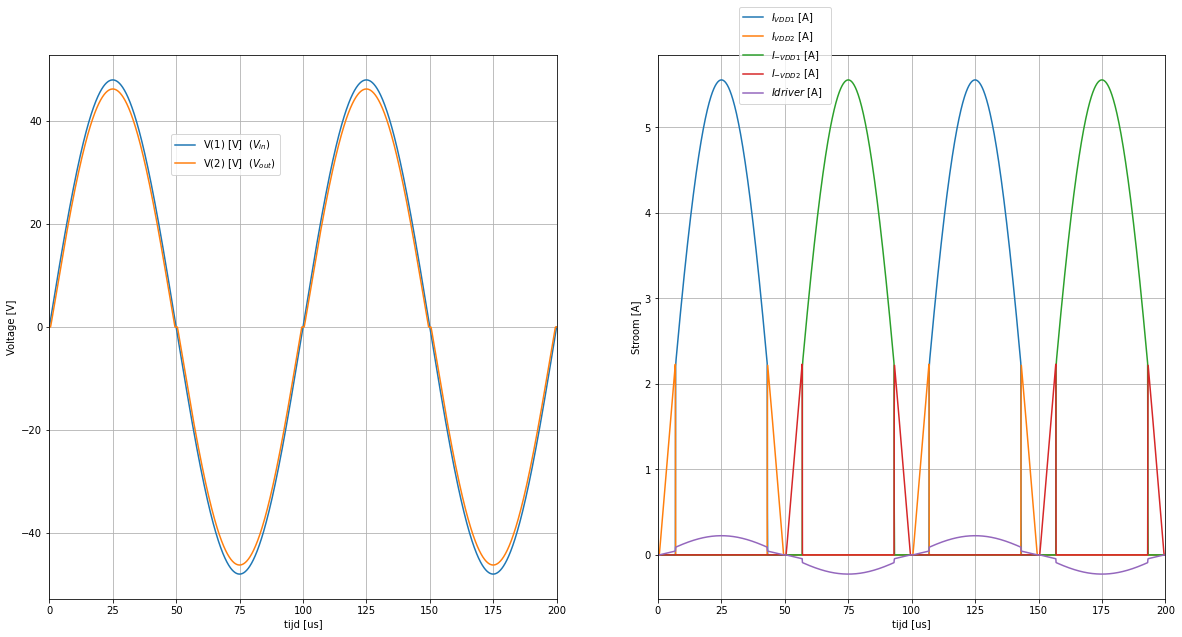

In [40]:
circuit=SpiceParser(path='simul\classG1.sp').build_circuit()     # CHECK DISTORTION WITH FOURIER SERIES ANALYSIS    ==> .FOUR 10KHZ V(12) 
end_time=2e-4
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=100e-9, end_time=end_time)

figure, ax = plt.subplots(1,2,figsize=(20, 10))
ax[0].plot(analysis.time*1e6,analysis.nodes['1'],label='V(1) [V]  ($V_{in}$)')
ax[0].plot(analysis.time*1e6,analysis.nodes['2'],label='V(2) [V]  ($V_{out}$)')
ax[0].legend( loc=(0.24,.78))
ax[0].grid()
ax[0].set_xlabel('tijd [us]')
ax[0].set_xlim(0,end_time*1e6)
ax[0].set_ylabel('Voltage [V]')

ax[1].plot(analysis.time*1e6,-analysis.branches['vpos1'],label='$I_{VDD1}$ [A] ')
ax[1].plot(analysis.time*1e6,-analysis.branches['vpos2'],label='$I_{VDD2}$ [A] ')
ax[1].plot(analysis.time*1e6,analysis.branches['vneg1'],label='$I_{-VDD1}$ [A]  ')
ax[1].plot(analysis.time*1e6,analysis.branches['vneg2'],label='$I_{-VDD2}$ [A]  ')
ax[1].plot(analysis.time*1e6,-analysis.branches['vs1'],label='$I driver$ [A]  ')
ax[1].legend( loc=(0.16,.91))
ax[1].grid()
ax[1].set_xlabel('tijd [us]')
ax[1].set_xlim(0,end_time*1e6)
ax[1].set_ylabel('Stroom [A]')
plt.show()

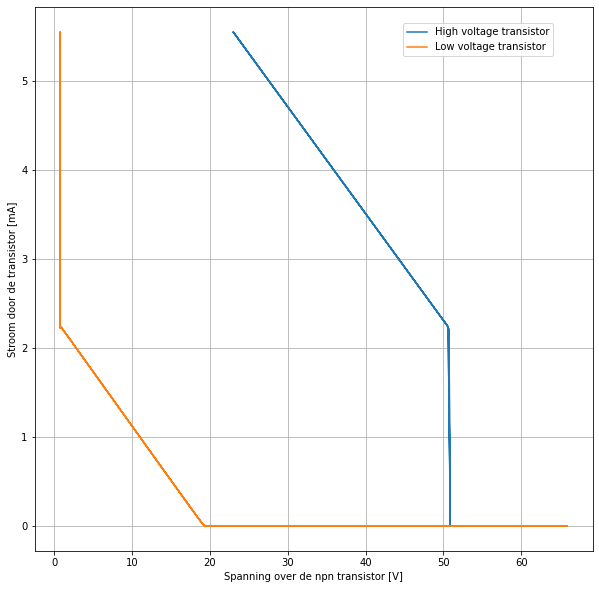

In [46]:
figure, ax = plt.subplots(figsize=(10, 10))
ax.plot(analysis.nodes['8']-analysis.nodes['9'],-analysis.branches['vpos1'],label='High voltage transistor')
ax.plot(analysis.nodes['9']-analysis.nodes['2'],-analysis.branches['vpos1']-analysis.branches['vpos2'],label='Low voltage transistor')
ax.grid()
ax.set_xlabel('Spanning over de npn transistor [V]')
ax.set_ylabel('Stroom door de transistor [mA]')
ax.legend( loc=(0.66,.91));